# Data Loading: Webdataset

## Overview

This example shows you how to use the data that is stored in the Webdataset format with DALI.

## Creating index

To use data that is stored in the Webdataset format, we need to use the `readers.webdataset` operator. In addition to the arguments that are common to all readers, such as `random_shuffle`, this operator takes `paths`, `index_paths`, `ext`, `missing_component_behavior` and `dtypes` arguments:

* `paths` the path (or list of paths) to the tar archives containing webdataset
* `index_paths` the path (or list of paths) to the respective index files containing data about the specifics of the tar files. Each index file only has to be generated once and can be created using the `wds2idx` utility included with DALI. For the specifics of the usage please refer to `wds2idx -h`
* `ext`  the extension set (or list of those) of extensions separated by a ';' that specify the outputs of the operator and which sample components will be fed into the specific outputs of the operator
* `missing_component_behavior` the behavior of the reader in case it encounters a sample that can't return provide any component to a certain output. There are 3 options:
    * `empty` (default) just returns an empty tensor for that output
    * `skip` the sample will be skipped and the next valid one will be taken
    * `error` an error will be raised
* `dtypes` the dtypes of the outputs of the operator. If the size of the output component is not divisible by the size of the type, an error will be thrown. INT8 if not provided.

The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [1]:
from subprocess import call
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
wds_data = os.path.join(test_data_root, 'db', 'webdataset', 'MNIST', "devel-0.tar")
batch_size = 16
wds_idx = "idx_files/train.idx"
wds2idx_script = "wds2idx"

if not os.path.exists("idx_files"):
    os.mkdir("idx_files")

if not os.path.isfile(wds_idx):
    call([wds2idx_script, wds_data, wds_idx])

## Defining and Running the Pipeline

1. Define a simple pipeline that takes the images stored in Webdataset format, decodes them, and prepares them for ingestion in DL framework.

   Processing images involves adding artificial noise and `HWC` -> `CHW` conversion process.

In [2]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np

@pipeline_def(batch_size=batch_size, num_threads=4, device_id=0)
def wds_pipeline(wds_data=wds_data, wds_idx=wds_idx):
    img_raw, cls = fn.readers.webdataset(
        paths=wds_data,
        index_paths=wds_idx,
        ext=["jpg;png", "cls"],
        missing_component_behavior="error")
    img = fn.decoders.image(img_raw, device="mixed", output_type=types.GRAY)
    img_float = fn.cast(img, dtype=types.FLOAT)
    
    # Adding noise so that it's harder for the network to train
    noised = fn.noise.salt_and_pepper(img, prob=0.05, salt_vs_pepper=0.7)
    blured = fn.gaussian_blur(noised, sigma=0.6)
    output = fn.jitter(blured)
    return output, cls

2. Build and run the pipeline:

In [3]:
pipe = wds_pipeline()
pipe.build()
pipe_out = pipe.run()

3. To visualize the results, use the `matplotlib` library, which expects images in `HWC` format, but the output of the pipeline is in `CHW`.

   **Note**: `CHW` is the preferred format for most Deep Learning frameworks.
   
4. For the visualization purposes, transpose the images back to the `HWC` layout.

In [12]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch, labels):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        ascii = labels.at(j)
        plt.title("".join([chr(item) for item in ascii]), fontdict={"fontsize": 30})
        img_chw = image_batch.at(j)
        img_hwc = np.transpose(img_chw, (2,0,1))/255.0
        plt.imshow(img_hwc[0], cmap="gray")

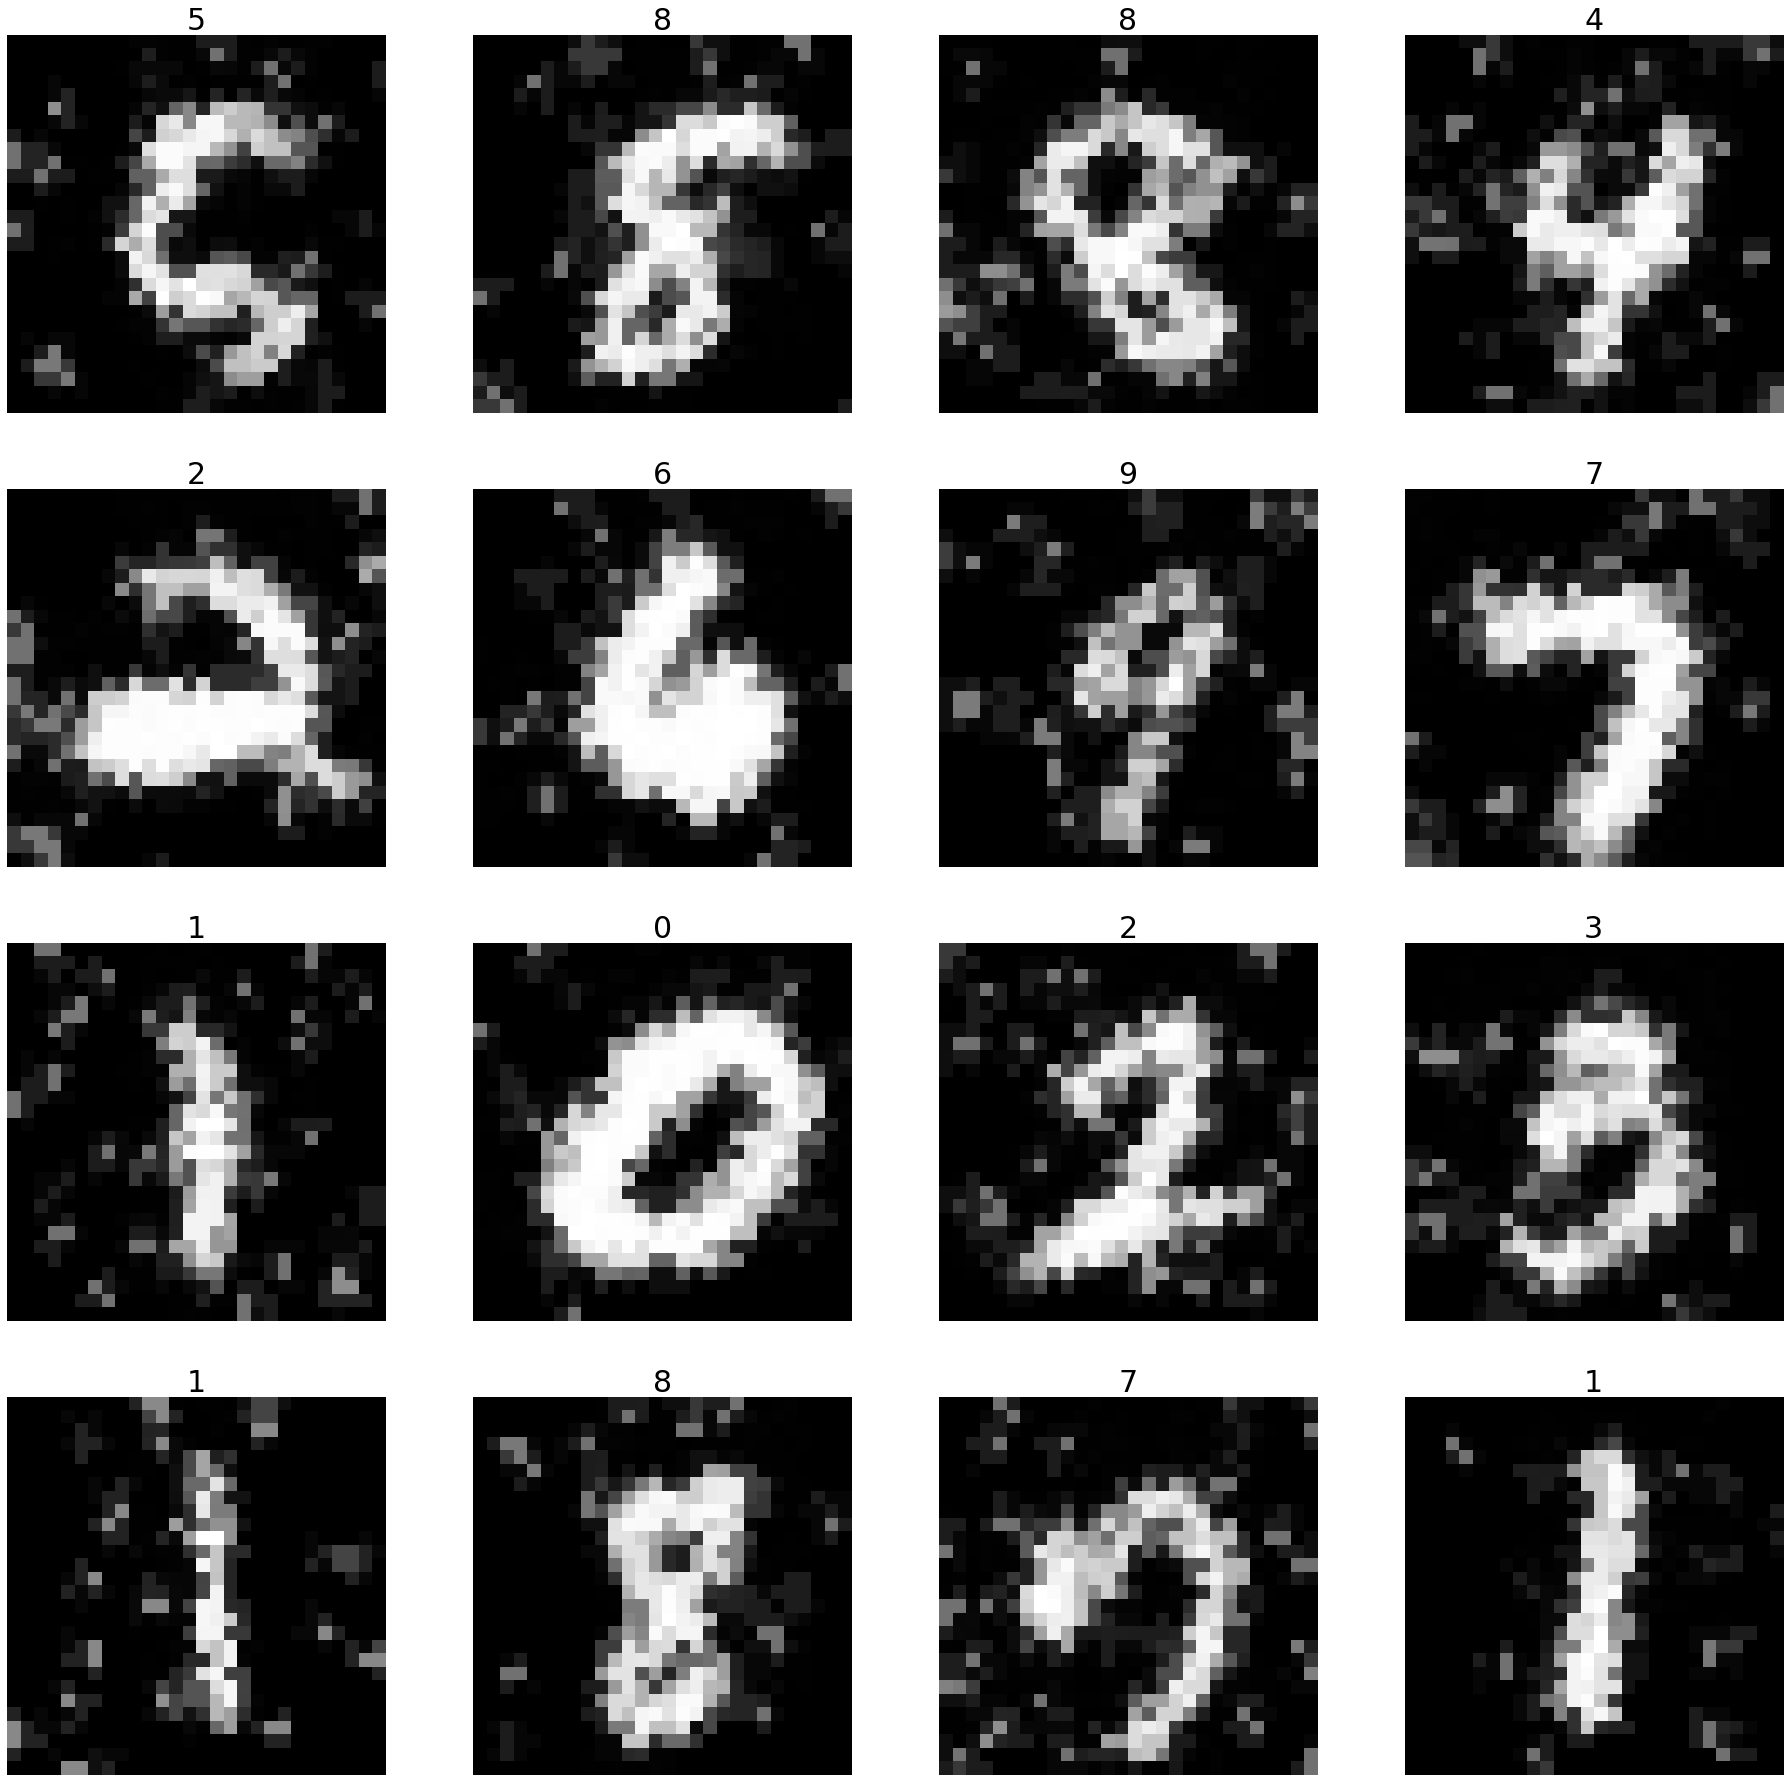

In [13]:
images, labels = pipe_out
show_images(images.as_cpu(), labels)